https://ithelp.ithome.com.tw/users/20120030/ironman/5515

# Day3-Hugging Face 本地端開發環境設定

In [1]:
#!pip install transformers

In [2]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis") #使用情感分析
classifier(
    [
        "寶寶覺得苦，但寶寶不說",
        "我愛寶寶"
    ]
)

2023-09-28 09:05:22.121620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 09:05:22.265132: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-28 09:05:22.945821: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-28 09:05:22.945921: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

[{'label': 'NEGATIVE', 'score': 0.9581432938575745},
 {'label': 'POSITIVE', 'score': 0.6695571541786194}]

# Day6-初探 Hugging Face Dataset Library

In [3]:
#pip install datasets

In [4]:
from datasets import load_dataset_builder
ds_builder = load_dataset_builder("poem_sentiment") #用load_dataset_builder 不會把資料下載下來

Using custom data configuration default


In [5]:
print(ds_builder.info.description)
print(ds_builder.info.features)

Poem Sentiment is a sentiment dataset of poem verses from Project Gutenberg. This dataset can be used for tasks such as sentiment classification or style transfer for poems.

{'id': Value(dtype='int32', id=None), 'verse_text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=4, names=['negative', 'positive', 'no_impact', 'mixed'], id=None)}


In [6]:
from datasets import load_dataset
sentiment = load_dataset("poem_sentiment") #下載資料

Using custom data configuration default
Reusing dataset poem_sentiment (/home/azureuser/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099)


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
sentiment

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})

In [8]:
#切割資料
train_ds = sentiment["train"]
valid_ds = sentiment["validation"]
test_ds = sentiment["test"]

In [9]:
#把 dataset 轉成 Pandas
import pandas as pd

sentiment.set_format(type="pandas")

df = sentiment["train"][:]

df.head(10)

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3
5,5,the red sword sealed their vows!,3
6,6,and very venus of a pipe.,2
7,7,"who the man, who, called a brother.",2
8,8,"and so on. then a worthless gaud or two,",0
9,9,to hide the orb of truth--and every throne,2


In [10]:
#把 label 轉成文字
def label_int2str(row):
	return sentiment["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head(10)

,id,verse_text,label,label_name
0,0,with pale blue berries. in these peaceful shad...,1,positive
1,1,"it flows so long as falls the rain,",2,no_impact
2,2,"and that is why, the lonesome day,",0,negative
3,3,"when i peruse the conquered fame of heroes, an...",3,mixed
4,4,of inward strife for truth and liberty.,3,mixed
5,5,the red sword sealed their vows!,3,mixed
6,6,and very venus of a pipe.,2,no_impact
7,7,"who the man, who, called a brother.",2,no_impact
8,8,"and so on. then a worthless gaud or two,",0,negative
9,9,to hide the orb of truth--and every throne,2,no_impact


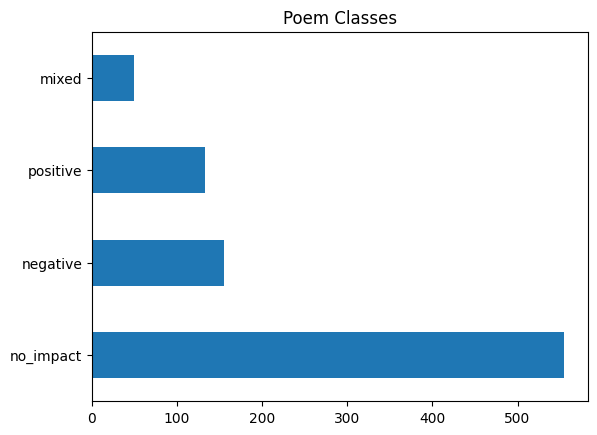

In [11]:
#dataset 的 label 分佈圖
import matplotlib.pyplot as plt

df["label_name"].value_counts().plot.barh()
plt.title("Poem Classes")
plt.show()

In [12]:
#可以把 pandas 處理過的轉成新的 dataset
from datasets import Dataset

label_name_dataset = Dataset.from_pandas(df)
label_name_dataset

Dataset({
    features: ['id', 'verse_text', 'label', 'label_name'],
    num_rows: 892
})

In [13]:
#shuffle 資料
sentiment_train = sentiment["train"].shuffle(seed=5566).select(range(100))

Loading cached shuffled indices for dataset at /home/azureuser/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099/cache-1dfaca19e9aa4441.arrow


In [14]:
#用詩句的長度過濾資料
sentiment_filtered = sentiment.filter(lambda x: len(x["verse_text"]) > 30)
sentiment_filtered

Parameter 'function'=<function <lambda> at 0x7effe5509b80> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 678
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 84
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 73
    })
})

In [15]:
#把詩句轉成文字長度
new_dataset = sentiment.map(
    lambda x: {"verse_text": [ len(o) for o in x["verse_text"] ] }, batched=True
)
new_dataset['test'][:3]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

,id,verse_text,label
0,0,29,2
1,1,69,1
2,2,44,2


# Day10-Tokenizer 入門

###### Character tokenization: 很難讓模型得出有意義的結論

In [16]:
#Character tokenization
string = "Only those who will risk going too far can possibly find out how far one can go."
tokenized_str = list(string)
print(tokenized_str)

['O', 'n', 'l', 'y', ' ', 't', 'h', 'o', 's', 'e', ' ', 'w', 'h', 'o', ' ', 'w', 'i', 'l', 'l', ' ', 'r', 'i', 's', 'k', ' ', 'g', 'o', 'i', 'n', 'g', ' ', 't', 'o', 'o', ' ', 'f', 'a', 'r', ' ', 'c', 'a', 'n', ' ', 'p', 'o', 's', 's', 'i', 'b', 'l', 'y', ' ', 'f', 'i', 'n', 'd', ' ', 'o', 'u', 't', ' ', 'h', 'o', 'w', ' ', 'f', 'a', 'r', ' ', 'o', 'n', 'e', ' ', 'c', 'a', 'n', ' ', 'g', 'o', '.']


In [17]:
#numericalization
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_str)))}
print(token2idx)

{' ': 0, '.': 1, 'O': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'k': 12, 'l': 13, 'n': 14, 'o': 15, 'p': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'w': 21, 'y': 22}


In [18]:
#把原始句子轉為數字
input_ids = [token2idx[token] for token in tokenized_str]
print(input_ids)

[2, 14, 13, 22, 0, 19, 10, 15, 18, 7, 0, 21, 10, 15, 0, 21, 11, 13, 13, 0, 17, 11, 18, 12, 0, 9, 15, 11, 14, 9, 0, 19, 15, 15, 0, 8, 3, 17, 0, 5, 3, 14, 0, 16, 15, 18, 18, 11, 4, 13, 22, 0, 8, 11, 14, 6, 0, 15, 20, 19, 0, 10, 15, 21, 0, 8, 3, 17, 0, 15, 14, 7, 0, 5, 3, 14, 0, 9, 15, 1]


###### Word tokenization: 很容易導致參數過大的問題

In [19]:
#Word tokenization
string = "Only those who will risk going too far can possibly find out how far one can go."
tokenized_str = string.split()
print(tokenized_str)

['Only', 'those', 'who', 'will', 'risk', 'going', 'too', 'far', 'can', 'possibly', 'find', 'out', 'how', 'far', 'one', 'can', 'go.']


In [20]:
#numericalization
token_word2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_str)))}
print(token_word2idx)

{'Only': 0, 'can': 1, 'far': 2, 'find': 3, 'go.': 4, 'going': 5, 'how': 6, 'one': 7, 'out': 8, 'possibly': 9, 'risk': 10, 'those': 11, 'too': 12, 'who': 13, 'will': 14}


In [21]:
#把原始句子轉為數字
input_ids = [token_word2idx[token] for token in tokenized_str]
print(input_ids)

[0, 11, 13, 14, 10, 5, 12, 2, 1, 9, 3, 8, 6, 2, 7, 1, 4]


# Day12-Hugging Face Tokenizer

In [22]:
from transformers import AutoTokenizer

string = "Only those who will risk going too far can possibly find out how far one can go."

model_name = "distilbert-base-uncased-finetuned-sst-2-english" #直接呼叫transformer model 名字
tokenizer = AutoTokenizer.from_pretrained(model_name) #自動使用該 transformer 所使用的 tokenizer

In [23]:
#指定 Tokenizer
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_name)

In [24]:
encoded_str = tokenizer(string, padding=True, truncation=True) 
encoded_str

{'input_ids': [101, 2069, 2216, 2040, 2097, 3891, 2183, 2205, 2521, 2064, 4298, 2424, 2041, 2129, 2521, 2028, 2064, 2175, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [25]:
#把編碼後的文字還原回來
tokens = tokenizer.convert_ids_to_tokens(encoded_str.input_ids)
tokens
'''
Special Token	  [PAD]	[UNK]	[CLS分類]	[SEP終止符號]	[MASK]
Special Token ID	0	100	    101	      102	         103
'''

'\nSpecial Token\t  [PAD]\t[UNK]\t[CLS分類]\t[SEP終止符號]\t[MASK]\nSpecial Token ID\t0\t100\t    101\t      102\t         103\n'

In [26]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] only those who will risk going too far can possibly find out how far one can go. [SEP]


In [27]:
#多句子分詞
string_array = [
    string,
    "Baby shark, doo doo doo doo doo doo, Baby shark!"
]

encoded_str_arr = tokenizer(string_array, padding=True, truncation=True)
encoded_str_arr

{'input_ids': [[101, 2069, 2216, 2040, 2097, 3891, 2183, 2205, 2521, 2064, 4298, 2424, 2041, 2129, 2521, 2028, 2064, 2175, 1012, 102], [101, 3336, 11420, 1010, 20160, 20160, 20160, 20160, 20160, 20160, 1010, 3336, 11420, 999, 102, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]}

In [28]:
from datasets import load_dataset
sentiment = load_dataset("poem_sentiment")

Using custom data configuration default
Reusing dataset poem_sentiment (/home/azureuser/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099)


  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
def tokenize(batch):
    return tokenizer(batch["verse_text"], padding=True, truncation=True)

print(tokenize(sentiment["train"][:3]))

{'input_ids': [[101, 2007, 5122, 2630, 22681, 1012, 1999, 2122, 9379, 13178, 1011, 1011, 102], [101, 2009, 6223, 2061, 2146, 2004, 4212, 1996, 4542, 1010, 102, 0, 0], [101, 1998, 2008, 2003, 2339, 1010, 1996, 10459, 14045, 2154, 1010, 102, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]}


In [30]:
#把整個資料集都做分詞
sentiment_encoded = sentiment.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [31]:
print(sentiment_encoded["train"].column_names)

['id', 'verse_text', 'label', 'input_ids', 'attention_mask']


In [32]:
print(sentiment_encoded["train"]["input_ids"])

[[101, 2007, 5122, 2630, 22681, 1012, 1999, 2122, 9379, 13178, 1011, 1011, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2009, 6223, 2061, 2146, 2004, 4212, 1996, 4542, 1010, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1998, 2008, 2003, 2339, 1010, 1996, 10459, 14045, 2154, 1010, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2043, 1045, 7304, 3366, 1996, 11438, 4476, 1997, 7348, 1010, 1998, 1996, 9248, 1997, 10478, 11593, 1010, 1045, 2079, 2025, 21103, 1996, 11593, 1010, 102, 0, 0], [101, 1997, 20546, 27865, 2005, 3606, 1998, 7044, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1996, 2417, 4690, 10203, 2037, 16495, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1998, 2200, 11691, 1997, 1037, 8667, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2040, 1996, 2158, 1010, 2040, 1010, 2170, 1037, 2567, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 19

In [33]:
print(sentiment_encoded["train"]["attention_mask"])

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0

# Day13-Hugging Face Transformer 入門

In [34]:
string_arr = [
    "Only those who will risk going too far can possibly find out how far one can go.",
    "Baby shark, doo doo doo doo doo doo, Baby shark!"
]
inputs = tokenizer(string_arr, padding=True, truncation=True, return_tensors="pt") #return pytorch 的 tensor
print(inputs)

{'input_ids': tensor([[  101,  2069,  2216,  2040,  2097,  3891,  2183,  2205,  2521,  2064,
          4298,  2424,  2041,  2129,  2521,  2028,  2064,  2175,  1012,   102],
        [  101,  3336, 11420,  1010, 20160, 20160, 20160, 20160, 20160, 20160,
          1010,  3336, 11420,   999,   102,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])}


In [35]:
#使用 Transformer Model
from transformers import AutoModelForSequenceClassification

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
outputs = model(**inputs)

In [36]:
print(outputs.logits)

tensor([[ 0.9738, -0.8098],
        [-1.1881,  1.2323]], grad_fn=<AddmmBackward0>)


In [37]:
#PyTorch
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)
'''
第一句話的結果是 [0.8561, 0.1439]: 第0個結果的機率是0.8561，第1個結果的機率是0.1439。
第二句話的結果是 [0.0816, 0.9184]: 第0個結果的機率是0.0816，第1個結果的機率是0.9184。
'''

tensor([[0.8561, 0.1439],
        [0.0816, 0.9184]], grad_fn=<SoftmaxBackward0>)


'\n第一句話的結果是 [0.8561, 0.1439]: 第0個結果的機率是0.8561，第1個結果的機率是0.1439。\n第二句話的結果是 [0.0816, 0.9184]: 第0個結果的機率是0.0816，第1個結果的機率是0.9184。\n'

In [38]:
#把 label 來打印出來
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

# Day14-Hugging Face Transformer Pipeline 和 TF model

In [39]:
#TensorFlow
from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_name)

2023-09-28 09:05:30.592947: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-28 09:05:30.592999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ironman2022): /proc/driver/nvidia/version does not exist
2023-09-28 09:05:30.593979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFDistilBertMo

# Day15- Fine-tune Transformer --- 資料處理篇

In [40]:
from datasets import load_dataset
sentiment = load_dataset("poem_sentiment")

Using custom data configuration default
Reusing dataset poem_sentiment (/home/azureuser/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099)


  0%|          | 0/3 [00:00<?, ?it/s]

In [41]:
#把 dataset 轉成 pandas
import pandas as pd

sentiment.set_format(type="pandas")
df = sentiment["train"][:]
df.head()

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3


In [42]:
def label_int2str(row):
    return sentiment["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,id,verse_text,label,label_name
0,0,with pale blue berries. in these peaceful shad...,1,positive
1,1,"it flows so long as falls the rain,",2,no_impact
2,2,"and that is why, the lonesome day,",0,negative
3,3,"when i peruse the conquered fame of heroes, an...",3,mixed
4,4,of inward strife for truth and liberty.,3,mixed


In [43]:
#把 lebels 指定為變數
labels = sentiment["train"].features["label"].names
print(labels)

['negative', 'positive', 'no_impact', 'mixed']


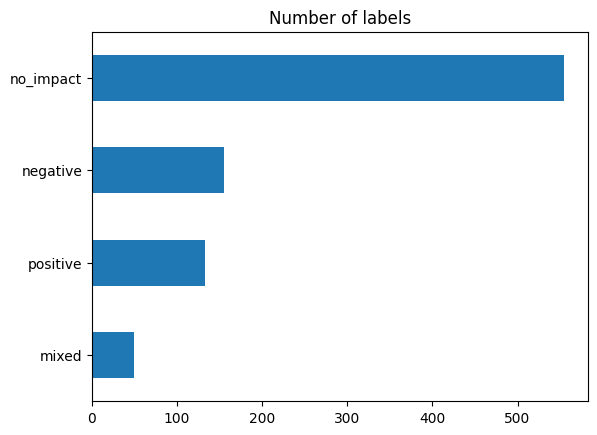

In [44]:
#把 dataset 的分布用 matplotlib 印出來
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Number of labels")
plt.show()

In [45]:
#把 dataset 的格式 reset 回來
sentiment.reset_format()

In [46]:
#呼叫分詞
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [47]:
#把資料集做分詞
def tokenize(batch):
    return tokenizer(batch["verse_text"], padding=True, truncation=True)

sentiment_encoded = sentiment.map(tokenize, batched=True, batch_size=None)
next(iter(sentiment_encoded["train"]))

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

{'id': 0,
 'verse_text': 'with pale blue berries. in these peaceful shades--',
 'label': 1,
 'input_ids': [101,
  2007,
  5122,
  2630,
  22681,
  1012,
  1999,
  2122,
  9379,
  13178,
  1011,
  1011,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [48]:
valid_ds = sentiment["validation"]
valid_ds["label"][:]
''' 
dataset validate 的部份，會發現裡面都沒有類別 3 ，未來可能會在做 validation 的時候產生 bug
'''

' \ndataset validate 的部份，會發現裡面都沒有類別 3 ，未來可能會在做 validation 的時候產生 bug\n'

# Day16- Fine-tune Transformer --- 訓練模型篇

In [49]:
#載入 PyTorch
import torch

#載入 pre-trained model
from transformers import AutoModelForSequenceClassification

#使用 CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#設定 label 的數量
num_labels = 4

#指定好 id2label 和 label2id
my_model = (AutoModelForSequenceClassification
        .from_pretrained(model_name, num_labels=num_labels #model_name = "distilbert-base-uncased"
        ,id2label={"0": "negative",
                    "1": "positive",
                    "2": "no_impact",
                    "3": "mixed"}
        ,label2id={"negative": "0",
                    "positive": "1",
                    "no_impact": "2",
                    "mixed": "3"})
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
#pip install transformers[torch]

In [51]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(sentiment_encoded["train"]) // batch_size
model_name = "poem_model"

#設定參數
training_args = TrainingArguments(output_dir=model_name, # checkpoint 和最後跑完的模型儲存位置
                                  num_train_epochs=40,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  report_to = "azure_ml", #Azure Machine Learning
                                  logging_steps=logging_steps)

In [52]:
#訓練模型的期間可以監控 accuracy_score 和 f1_score
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [53]:
#開始訓練模型
from transformers import Trainer

trainer = Trainer(model=my_model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=sentiment_encoded["train"],
                  eval_dataset=sentiment_encoded["validation"],
                  tokenizer=tokenizer)

In [54]:
#trainer.evaluate()

In [55]:
#trainer.train()

In [56]:
# 用pipeline載入模型
from transformers import pipeline

classifier = pipeline(task= 'sentiment-analysis', 
                      model= "poem_model/checkpoint-500")

In [57]:
classifier(
    [
        "Only those who will risk going too far can possibly find out how far one can go.",
        "Baby shark, doo doo doo doo doo doo, Baby shark!"
    ]
)

[{'label': 'no_impact', 'score': 0.993340790271759},
 {'label': 'no_impact', 'score': 0.9961262345314026}]

# Day18-Hugging Face 文本生成入門

###### 根據輸入的提示，產生輸出 => 條件式文本生成(conditional text generation)

In [58]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

###### 方法1: 得到 logits 再過 softmax 選最高機率

In [59]:
input_txt = "I have a pen, I have an "
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 10
choices_per_step = 3

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids)
        # 選最後一個 token 然後過 softmax 後選出機率最大
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

print(iterations[-1])

{'Input': 'I have a pen, I have an iphone, I have a laptop, I'}


###### 方法2: 使用 generate()

In [60]:
max_length = 64
input_txt = """I have a pen, I have an iphone, I have a laptop. Thus,"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_length=max_length)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have a pen, I have an iphone, I have a laptop. Thus, I have a lot of things that I can use to communicate with people. I can use my phone to send a text message, I can use my laptop to send a picture, I can use my pen to write a letter


# Day19-Hugging Face 文本生成進階

###### 方法1: Greedy Search貪婪搜尋
###### 缺點: 產出大量重複的字句
###### 應用場景: 精確任務或為特定問題提供答案

In [61]:
max_length = 256

input_txt = """
Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. \n
The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that \
the 37 billion part-nationalisation last yearr has failed to keep credit flowing,
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_length=max_length, num_beams=1,  do_sample=False)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. 

The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that the 37 billion part-nationalisation last yearr has failed to keep credit flowing,

The Chancellor will also consider whether to take a second look at the Bank of England's plans to raise interest rates, which have been held at a record low of 0.5 per cent since March 2009.

The Chancellor will also consider whether to take a second look at the Bank of England's plans to raise interest rates, which have been held at a record low of 0.5 per cent since March 2009.

The Chancellor will also consider whether to take a second look at the Bank of England's plans to raise interest rates, which have been held at a record low of 0.5 per cent since March 2009.

The Chancellor will also consider whether to take a second look at the Bank of England's plans to raise interest rates, whic

###### 方法2: Beam Search波束搜尋
###### 應用場景: 精確任務或為特定問題提供答案

In [62]:
max_length = 256

input_txt = """
Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. \n
The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that \
the 37 billion part-nationalisation last yearr has failed to keep credit flowing,
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_length=max_length, num_beams=3,  do_sample=False, no_repeat_ngram_size=5)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. 

The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that the 37 billion part-nationalisation last yearr has failed to keep credit flowing,

Mr Darling said: "We have to look at what we can do to help the banks.

"We have to think about what we can do for the economy.

"It is not just about the banks, it is about the economy as a whole.

"If we don't do something to help the banks, the economy is going to suffer."

He added: "We have got to get the banks lending again.

"They have got to be able to lend to businesses and to households.

"That is the only way we are going to get the economy moving again."

Mr Darling's comments came as the Bank of England warned that the UK economy could be heading for a "hard landing".

The Bank's chief economist, Andy Haldane, said: "The UK economy is in a fragile state.

"There is a risk of a h

###### 方法3: Sampling取樣
###### 應用場景: 生成更長或更有創意的文本

In [63]:
max_length = 256

input_txt = """
Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. \n
The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that \
the 37 billion part-nationalisation last yearr has failed to keep credit flowing,
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_length=max_length, num_beams=1, do_sample=True, temperature=1.5)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. 

The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that the 37 billion part-nationalisation last yearr has failed to keep credit flowing,

Meanwhile George Osborne can do nothing further without triggering a major market repricing up into risky assets and triggering an economic disaster. 

And yet even this is seen by some MPs and peers as an insufficient step for the Government : Mr Davis said any further support for the banks should stop short of a guarantee — or bank deposit guarantee — akin to some US state deposit insurance measures. And he said it should stop "pouring a further billion [pounds] in."

I have heard you speak in the Commons. Let me tell my comrades who were here today for parliamentary work, the truth about government financial support. If we consider any further Government credit the following statement has

In [64]:
max_length = 256

input_txt = """
Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. \n
The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that \
the 37 billion part-nationalisation last yearr has failed to keep credit flowing,
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_length=max_length, num_beams=1, do_sample=True, top_k=50)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. 

The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that the 37 billion part-nationalisation last yearr has failed to keep credit flowing,

He called for some form of "bridge plan" by the Bank to keep the economy from going over a cliff.

Asked if the Government should introduce another round of lending in order to keep the economy afloat, Mr Darling said: "Well I certainly think that a bridge plan should be thought through for the banking system in terms of providing more loans."<|endoftext|>


In [65]:
max_length = 256

input_txt = """
Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. \n
The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that \
the 37 billion part-nationalisation last yearr has failed to keep credit flowing,
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_length=max_length, num_beams=1, do_sample=True, top_p=0.95)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. 

The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that the 37 billion part-nationalisation last yearr has failed to keep credit flowing,

"I believe the decision to go for further injections could be made, but that depends on the availability of additional borrowing power," said Lord Lamont, the former deputy chairman of the Bank of England.

"It may well be that the banks are not in a position to undertake that amount of new lending. And if they are not in a position to do that, the question arises whether they can borrow the additional 10billion in loans that would be required."

The National Audit Office has forecast that the country's credit ratings could be downgraded at any point, as the UK's economy slips into recession.

It also revealed that some £1.9billion in public sector loans are at risk - with up to £400million 

# Day20-Hugging Face 中文的文本生成

In [66]:
from transformers import BertTokenizerFast,AutoModelForCausalLM

tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = AutoModelForCausalLM.from_pretrained('ckiplab/gpt2-base-chinese').to(device)

In [67]:
max_length=256

input_txt = """
隨著貸款日益枯竭，Alistair Darling 被迫考慮對銀行進行第二次救助。 \
財政大臣將在幾週內決定是否向經濟中再注入數十億美元，因為有證據表明\
去年 370 億的部分國有化未能保持信貸流動，
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_length=max_length, num_beams=1,  do_sample=True, top_k=50)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:102 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


[CLS] 隨 著 貸 款 日 益 枯 竭 ， [UNK] [UNK] 被 迫 考 慮 對 銀 行 進 行 第 二 次 救 助 。 財 政 大 臣 將 在 幾 週 內 決 定 是 否 向 經 濟 中 再 注 入 數 十 億 美 元 ， 因 為 有 證 據 表 明 去 年 370 億 的 部 分 國 有 化 未 能 保 持 信 貸 流 動 ， [SEP] 是 銀 行 的 [UNK] 重 整 並 沒 有 被 [UNK] [UNK] 打 破 。 2013 年 7 月 ， 一 批 私 人 [UNK] 在 英 國 的 大 型 基 金 集 資 ， 以 及 投 資 基 金 集 團 ， 發 揮 了 一 系 列 的 功 能 。 基 金 計 劃 使 得 [UNK] [UNK] [UNK] 基 金 的 大 部 分 股 份 出 售 給 了 [UNK] [UNK] 集 團 ， 總 部 在 倫 敦 。 大 英 帝 國 的 大 型 基 金 公 司 ， 包 括 了 紐 約 [UNK] 集 團 以 及 阿 姆 斯 特 丹 [UNK] 基 金 管 理 有 限 公 司 。 在 2014 年 的 全 球 金 融 危 機 中 ， 大 型 企 業 投 資 了 數 千 億 美 元 資 金 ， 以 及 對 政 府 投 資 數 百 億 美 元 資 金 投 入 資 金 開 展 了 市 場 流


# Day21-Hugging Face 摘要任務入門

###### Encoder-Decoder transformer

In [68]:
input_text="""
Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. 

The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that the 37 billion part-nationalisation last yearr has failed to keep credit flowing,

Mr Darling, the former Liberal Democrat chancellor, admitted that the situation had become critical but insisted that there was still time to turn things around. 

He told the BBC that the crisis in the banking sector was the most serious problem facing the economy but also highlighted other issues, such as the falling value of sterling and the threat of inflation. 

"The worst fears about the banking crisis seem not to be panning out," he said, adding that there had not been a single banker arrested or charged over the crash. 

"The economy, the economy"

Mr Darling said "there's been a very, very strong recovery" since the autumn of 2008.

"There are very big problems ahead of us, not least of which is inflation. It is likely to be a very high inflation rate. "

The economy is expected to grow by 0.3% in the quarter to the end of this year.
"""

In [69]:
from transformers import pipeline

pipe = pipeline("summarization", model="t5-large")
result = pipe(input_text)
result

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


[{'summary_text': 'former lib dem chancellor forced to consider second bailout for banks . evidence mounts that 37 billion part-nationalisation last yearr has failed to keep credit flowing . darling insists that there is still time to turn things around .'}]

In [70]:
pipe_pegasus = pipeline("summarization", model="google/pegasus-cnn_dailymail")
result_pegasus = pipe_pegasus(input_text)
result_pegasus

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'summary_text': 'Mr Darling admitted that the situation had become critical but insisted that there was still time to turn things around .<n>The economy is expected to grow by 0.3% in the quarter to the end of this year .'}]

In [71]:
#pip install nltk

In [72]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [73]:
string = "The U.S. are a country. Mr. White vs. Heisenberg."

sent_tokenize(string)

['The U.S. are a country.', 'Mr. White vs. Heisenberg.']

In [74]:
#整理摘要結果
paragraph_result_T5 = "\n".join(sent_tokenize(result[0]["summary_text"]))
print(paragraph_result_T5)

print()

paragraph_result_pegasus = "\n".join(sent_tokenize(result_pegasus[0]["summary_text"].replace(" .<n>", " .\n")))
print(paragraph_result_pegasus)

former lib dem chancellor forced to consider second bailout for banks .
evidence mounts that 37 billion part-nationalisation last yearr has failed to keep credit flowing .
darling insists that there is still time to turn things around .

Mr Darling admitted that the situation had become critical but insisted that there was still time to turn things around .
The economy is expected to grow by 0.3% in the quarter to the end of this year .


# Day22-評價摘要好壞的演算法

In [75]:
#pip install rouge_score

In [76]:
from datasets import load_metric

rouge_metric = load_metric("rouge")

In [77]:
scores = rouge_metric.compute(
    predictions=[paragraph_result_T5], references=[input_text]
)
print(scores)

{'rouge1': AggregateScore(low=Score(precision=0.918918918918919, recall=0.1691542288557214, fmeasure=0.2857142857142857), mid=Score(precision=0.918918918918919, recall=0.1691542288557214, fmeasure=0.2857142857142857), high=Score(precision=0.918918918918919, recall=0.1691542288557214, fmeasure=0.2857142857142857)), 'rouge2': AggregateScore(low=Score(precision=0.6666666666666666, recall=0.12, fmeasure=0.20338983050847456), mid=Score(precision=0.6666666666666666, recall=0.12, fmeasure=0.20338983050847456), high=Score(precision=0.6666666666666666, recall=0.12, fmeasure=0.20338983050847456)), 'rougeL': AggregateScore(low=Score(precision=0.8378378378378378, recall=0.15422885572139303, fmeasure=0.26050420168067223), mid=Score(precision=0.8378378378378378, recall=0.15422885572139303, fmeasure=0.26050420168067223), high=Score(precision=0.8378378378378378, recall=0.15422885572139303, fmeasure=0.26050420168067223)), 'rougeLsum': AggregateScore(low=Score(precision=0.918918918918919, recall=0.16915

In [78]:
scores = rouge_metric.compute(
    predictions=[paragraph_result_pegasus], references=[input_text]
)
print(scores)

{'rouge1': AggregateScore(low=Score(precision=1.0, recall=0.1890547263681592, fmeasure=0.3179916317991632), mid=Score(precision=1.0, recall=0.1890547263681592, fmeasure=0.3179916317991632), high=Score(precision=1.0, recall=0.1890547263681592, fmeasure=0.3179916317991632)), 'rouge2': AggregateScore(low=Score(precision=0.9459459459459459, recall=0.175, fmeasure=0.29535864978902954), mid=Score(precision=0.9459459459459459, recall=0.175, fmeasure=0.29535864978902954), high=Score(precision=0.9459459459459459, recall=0.175, fmeasure=0.29535864978902954)), 'rougeL': AggregateScore(low=Score(precision=1.0, recall=0.1890547263681592, fmeasure=0.3179916317991632), mid=Score(precision=1.0, recall=0.1890547263681592, fmeasure=0.3179916317991632), high=Score(precision=1.0, recall=0.1890547263681592, fmeasure=0.3179916317991632)), 'rougeLsum': AggregateScore(low=Score(precision=1.0, recall=0.1890547263681592, fmeasure=0.3179916317991632), mid=Score(precision=1.0, recall=0.1890547263681592, fmeasure=

# Day23- Fine-tuned 摘要任務的 transformer

In [79]:
dataset_url = "https://huggingface.co/datasets/gopalkalpande/bbc-news-summary/raw/main/bbc-news-summary.csv"

In [80]:
#載入 dataset
from datasets import load_dataset
remote_dataset = load_dataset("csv", data_files=dataset_url)

  0%|          | 0/1 [00:00<?, ?it/s]

In [81]:
import pandas as pd

remote_dataset.set_format(type="pandas")

df = remote_dataset["train"][:]

df.head(10)

,File_path,Articles,Summaries
0,politics,Budget to set scene for election..Gordon Brown...,- Increase in the stamp duty threshold from £6...
1,politics,Army chiefs in regiments decision..Military ch...,"""They are very much not for the good and will ..."
2,politics,Howard denies split over ID cards..Michael How...,Michael Howard has denied his shadow cabinet w...
3,politics,Observers to monitor UK election..Ministers wi...,The report said individual registration should...
4,politics,Kilroy names election seat target..Ex-chat sho...,"UKIP's leader, Roger Knapman, has said he is g..."
5,politics,Donor attacks Blair-Brown 'feud'..The reported...,"Mr Bannatyne has previously given Labour £50,0..."
6,politics,Research fears over Kelly's views..Scientists ...,Medical Research Council Professor Nancy Rothw...
7,politics,Chancellor rallies Labour voters..Gordon Brown...,"He said Tory plans to cut £35bn tax would ""cut..."
8,politics,Fox attacks Blair's Tory 'lies'..Tony Blair li...,Mr Blair said that whether the public chose Mi...
9,politics,Tories unveil quango blitz plans..Plans to abo...,Six government units would also be scrapped un...


In [82]:
remote_dataset.reset_format()

In [83]:
train_dataset = remote_dataset.shuffle(seed=5566)

In [84]:
from datasets import DatasetDict

train_test_dataset = train_dataset['train'].train_test_split(test_size=0.1)

test_valid = train_test_dataset['test'].train_test_split(test_size=0.5)

train_test_valid_dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['File_path', 'Articles', 'Summaries'],
        num_rows: 2001
    })
    test: Dataset({
        features: ['File_path', 'Articles', 'Summaries'],
        num_rows: 112
    })
    valid: Dataset({
        features: ['File_path', 'Articles', 'Summaries'],
        num_rows: 111
    })
})

In [85]:
from transformers import AutoModelForSeq2SeqLM,AutoTokenizer
import torch

model_name = "google/pegasus-cnn_dailymail"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
def convert_dataset(dataset):
    input_encodings = tokenizer(dataset["Articles"], max_length=512,
                                truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(dataset["Summaries"], max_length=64,
                                     truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_pt = train_test_valid_dataset.map(convert_dataset,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_pt.set_format(type="torch", columns=columns)

  0%|          | 0/3 [00:00<?, ?ba/s]

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [87]:
from transformers import Seq2SeqTrainingArguments, trainer

model_saved_name = model_name.split("/")[-1] 

args = Seq2SeqTrainingArguments( 
    output_dir=f"{model_name}-finetuned", 
    num_train_epochs=1, 
    warmup_steps=100,
    per_device_train_batch_size=1, 
    per_device_eval_batch_size=1,
    weight_decay=0.01, 
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=100, 
    save_steps=1e6,
    gradient_accumulation_steps=64,
    report_to="azure_ml"
)

In [88]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [89]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [90]:
from datasets import load_metric

rouge_metric = load_metric("rouge")

In [91]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # 這裡把 DataCollatorForSeq2Seq 會填入的 -100 排除掉
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]

    result = rouge_metric.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [92]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset= dataset_pt["train"],
    eval_dataset = dataset_pt["valid"],
    data_collator=seq2seq_data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [93]:
#trainer.evaluate()

In [94]:
#trainer.train()

# Day24- Hugging Face Named Entity Recognition

###### Named Entity Recognition(NER)。 一般翻譯為命名實體辨識、命名實體識別，或也有人翻成專有名詞辨識

In [95]:
sample_text = """
Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. 

The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that the 37 billion part-nationalisation last yearr has failed to keep credit flowing,

Mr Darling, the former Liberal Democrat chancellor, admitted that the situation had become critical but insisted that there was still time to turn things around. 

He told the BBC that the crisis in the banking sector was the most serious problem facing the economy but also highlighted other issues, such as the falling value of sterling and the threat of inflation. 

"The worst fears about the banking crisis seem not to be panning out," he said, adding that there had not been a single banker arrested or charged over the crash. 

"The economy, the economy"

Mr Darling said "there's been a very, very strong recovery" since the autumn of 2008.

"There are very big problems ahead of us, not least of which is inflation. It is likely to be a very high inflation rate. "

The economy is expected to grow by 0.3% in the quarter to the end of this year.
"""

In [96]:
from transformers import pipeline
import pandas as pd


ner = pipeline("ner")
outputs = ner(sample_text)
pd.DataFrame(outputs)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,entity,score,index,word,start,end
0,I-PER,0.998788,1,Alistair,1,9
1,I-PER,0.999182,2,Darling,10,17
2,I-PER,0.999369,62,Darling,303,310
3,I-ORG,0.684849,66,Liberal,323,330
4,I-MISC,0.685733,67,Democrat,331,339
5,I-ORG,0.993240,92,BBC,476,479
6,I-PER,0.999317,173,Darling,866,873


# Day25- Hugging Face 問答任務

In [97]:
question = "who is Mr Darling"
context = """
Alistair Darling has been forced to consider a second bailout for banks as the lending drought worsens. 

The Cancellor will decide tithin weeks whether to pump billions more into the economy as evidence mounts that the 37 billion part-nationalisation last yearr has failed to keep credit flowing,

Mr Darling, the former Liberal Democrat chancellor, admitted that the situation had become critical but insisted that there was still time to turn things around. 

He told the BBC that the crisis in the banking sector was the most serious problem facing the economy but also highlighted other issues, such as the falling value of sterling and the threat of inflation. 

"The worst fears about the banking crisis seem not to be panning out," he said, adding that there had not been a single banker arrested or charged over the crash. 

"The economy, the economy"

Mr Darling said "there's been a very, very strong recovery" since the autumn of 2008.

"There are very big problems ahead of us, not least of which is inflation. It is likely to be a very high inflation rate. "

The economy is expected to grow by 0.3% in the quarter to the end of this year.
"""

In [98]:
from transformers import AutoModelForQuestionAnswering
from transformers import AutoTokenizer

model_name = "deepset/roberta-base-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

In [99]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, top_k=3) #top_k=3: 會秀選出機率最高的答案前三名

[{'score': 0.28790101408958435,
  'start': 316,
  'end': 350,
  'answer': 'former Liberal Democrat chancellor'},
 {'score': 0.27082088589668274,
  'start': 312,
  'end': 350,
  'answer': 'the former Liberal Democrat chancellor'},
 {'score': 0.238358736038208,
  'start': 323,
  'end': 350,
  'answer': 'Liberal Democrat chancellor'}]

In [100]:
question = "What is the problem Mr Darling told to BBC?"

In [101]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, top_k=3)

[{'score': 0.41947636008262634,
  'start': 485,
  'end': 517,
  'answer': 'the crisis in the banking sector'},
 {'score': 0.2781962454319,
  'start': 489,
  'end': 517,
  'answer': 'crisis in the banking sector'},
 {'score': 0.05736870691180229,
  'start': 499,
  'end': 517,
  'answer': 'the banking sector'}]

# Day27-Transformer 效能優化

In [102]:
#pip install optimum

In [103]:
#pip install torch torchvision torchaudio

In [104]:
#pip install --upgrade transformers

In [105]:
from transformers import AutoTokenizer, pipeline
from optimum.onnxruntime import ORTModelForQuestionAnswering

model = ORTModelForQuestionAnswering.from_pretrained("optimum/roberta-base-squad2") 
tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")

onnx_qa = pipeline("question-answering",model=model,tokenizer=tokenizer)

question = "What's my name?"
context = "My name is Ko Ko and I live in Taiwan."
result = onnx_qa(question, context)

print(result)

{'score': 0.9248433709144592, 'start': 11, 'end': 16, 'answer': 'Ko Ko'}
